In [1]:
# %%
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, plot_confusion_matrix
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

In [2]:
# Read in and examine data
titanic_train = pd.read_csv('C:\\Users\\avhw\\DataScience\\DSDP\\Trees\\titanic_train.csv')
titanic_train.head()

# Subset data by columns to keep
titanic_keep = ["Survived", "Pclass", "Sex", "Age", "SibSp",
                "Parch", "Fare", "Embarked"]
titanic_for_trees = titanic_train[titanic_keep]

In [3]:
# Remove missing values
titanic_for_trees = titanic_for_trees.dropna()
titanic_for_trees = titanic_for_trees.reset_index(drop=True)

# Split up X and y matrices
X = titanic_for_trees.drop(columns="Survived")
y = titanic_for_trees["Survived"]

In [4]:
# One-hot encode categorical variables
categorical_variables = ["Pclass", "Sex", "Embarked"]
continuous_variables = ["Age", "SibSp", "Parch"]

one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X[categorical_variables])
X_ohed = one_hot_encoder.transform(X[categorical_variables]).toarray()
X_ohed = pd.DataFrame(X_ohed,
                      columns=one_hot_encoder.get_feature_names(categorical_variables))

In [5]:
# Merge one-hot encoded categorical variables with continuous variables
X = pd.concat([X[continuous_variables], X_ohed], axis=1)
X.head()


,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,26.0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,35.0,1,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35.0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [6]:
# Create classifier with default tree pruning hyperparameters and fit to data
classifier_def = tree.DecisionTreeClassifier()
classifier_def.fit(X, y)


DecisionTreeClassifier()

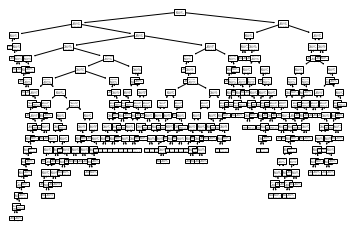

In [7]:
# Takes a second to generate the tree
# Note the difference in default cp value in sklearn (0.0) resulting in a full tree
tree_plot_def = tree.plot_tree(classifier_def)

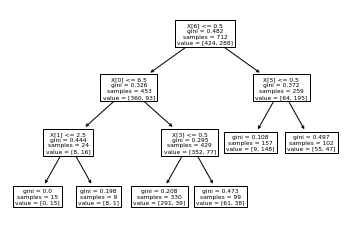

In [30]:
# Modulate the complexity parameter to result in a far smaller tree
# Experiment with different tree parameters using the definitions here:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
classifier_cp = tree.DecisionTreeClassifier(ccp_alpha=0.01)
classifier_cp.fit(X, y)
tree_plot_cp = tree.plot_tree(classifier_cp)

In [9]:

# %%
# Tree refinement

# Evaluation function calculating a number of helpful error metrics


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        test_labels, predictions, average='binary')
    accuracy = accuracy_score(y_pred=predictions, y_true=test_labels)
    mcc = matthews_corrcoef(y_pred=predictions, y_true=test_labels)

    print('Model Performance')
    print('Precision = {:0.2f}%.'.format(precision))
    print('Recall = {:0.2f}%.'.format(recall))
    print('F1-Score = {:0.2f}%.'.format(f1_score))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MCC = {:0.2f}%.'.format(mcc))

    return [precision, recall, f1_score, accuracy, mcc]




Best CV accuracy: 0.8073469387755102, with parameters: {'ccp_alpha': 0.0, 'max_depth': 3}
Model Performance
Precision = 0.80%.
Recall = 0.62%.
F1-Score = 0.70%.
Accuracy = 0.78%.
MCC = 0.53%.


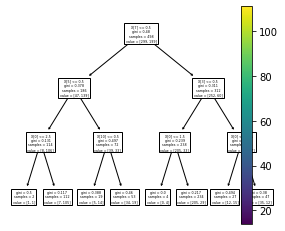

In [29]:
# Split data into a 70/30 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123)

# Use a grid search over a specified range of possible hyperparameter values
parameters = {
    'max_depth': range(3, 15),
    'ccp_alpha': np.arange(0.0, .2, .01)
}

# Run grid search over hyperparameter ranges
classifier = GridSearchCV(tree.DecisionTreeClassifier(),
                          parameters,
                          cv=10,
                          n_jobs=-1
                          )
classifier.fit(X=X_train, y=y_train)

# Extract best CV model and print its accuracy measure
cv_best_model = classifier.best_estimator_
print("Best CV accuracy: {}, with parameters: {}".format(
    classifier.best_score_, classifier.best_params_))

# Evaluate best CV model on holdout test set
precision, recall, f1_score, accuracy, mcc = evaluate(
    cv_best_model, X_test, y_test)

# Plot confusion matrix and best decision tree
plot_confusion_matrix(cv_best_model, X_test, y_test)
cv_best_model_plot = tree.plot_tree(cv_best_model)

# %%


Test at least three values each for the hyperparameters mentioned in the lecture in addition to than the complexity parameter using scikit-learn’s GridSearchCV function.  What are your findings?

In [15]:
for n in range(3):
  print(n)

0
1
2


In [16]:
print(np.arange(0, .2, .01))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19]


this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned.

CP: factor between 0 and 1 which penalizes the number of tree splits
cp = 0 , full topography is recovered
cp =  1, nly root is present